## 3.1 KNN Clustering Example 2 (ASTEROIDS)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('asteroids_dataset.csv', low_memory=False)

In [3]:
data.isnull().sum()

id                     0
spkid                  0
full_name              0
pdes                   0
name              936460
prefix            958506
neo                    4
pha                19921
H                   6263
diameter          822315
albedo            823421
diameter_sigma    822443
orbit_id               0
epoch                  0
epoch_mjd              0
epoch_cal              0
equinox                0
e                      0
a                      0
q                      0
i                      0
om                     0
w                      0
ma                     1
ad                     4
n                      0
tp                     0
tp_cal                 0
per                    4
per_y                  1
moid               19921
moid_ld              127
sigma_e            19922
sigma_a            19922
sigma_q            19922
sigma_i            19922
sigma_om           19922
sigma_w            19922
sigma_ma           19922
sigma_ad           19926


In [4]:
#dropping features with too many missing value and id, spkid and full_name
data.drop(['name','prefix','diameter','albedo','diameter_sigma','id','spkid','full_name'],axis=1,inplace=True)

In [5]:
data.shape

(958524, 37)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 37 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   pdes       958524 non-null  object 
 1   neo        958520 non-null  object 
 2   pha        938603 non-null  object 
 3   H          952261 non-null  float64
 4   orbit_id   958524 non-null  object 
 5   epoch      958524 non-null  float64
 6   epoch_mjd  958524 non-null  int64  
 7   epoch_cal  958524 non-null  float64
 8   equinox    958524 non-null  object 
 9   e          958524 non-null  float64
 10  a          958524 non-null  float64
 11  q          958524 non-null  float64
 12  i          958524 non-null  float64
 13  om         958524 non-null  float64
 14  w          958524 non-null  float64
 15  ma         958523 non-null  float64
 16  ad         958520 non-null  float64
 17  n          958524 non-null  float64
 18  tp         958524 non-null  float64
 19  tp_cal     958524 non-n

In [7]:
# to classify by pha
ytarget = data['class']

Xdata = data.select_dtypes(exclude=['object'])
Xdata.dropna(inplace=True)


In [8]:
ytarget.unique()

array(['MBA', 'OMB', 'MCA', 'AMO', 'IMB', 'TJN', 'CEN', 'APO', 'ATE',
       'AST', 'TNO', 'IEO', 'HYA'], dtype=object)

In [9]:
# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_std = StandardScaler().fit_transform(Xdata)
X_rank = np.linalg.matrix_rank(X_std)
pca = PCA(n_components=X_rank)
X_transformed = pca.fit_transform(X_std)
cum_variance_explained = pca.explained_variance_ratio_.cumsum()
cum_variance_explained

array([0.15007038, 0.28156725, 0.39646047, 0.501926  , 0.59136973,
       0.65431242, 0.70126095, 0.74121873, 0.77797238, 0.81178762,
       0.84402051, 0.8731902 , 0.90095384, 0.92493218, 0.94778676,
       0.96988617, 0.98163044, 0.9929652 , 0.99661852, 0.99891051,
       0.99982998, 0.99988643, 0.99993227, 0.99997521, 0.99999342,
       1.        , 1.        ])

In [10]:
import numpy as np

THRESHOLD = .95
idx = np.where(np.cumsum(pca.explained_variance_ratio_)>THRESHOLD)[0][0]

num_latent_dim = idx + 1
pca = PCA(n_components=num_latent_dim)
X_pca = pca.fit_transform(X_std)
print('Number of latent dimensions for pca: ' + str(num_latent_dim))

Number of latent dimensions for pca: 16


In [24]:
from sklearn.cluster import KMeans

Ks = range(2, 16)
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_pca) for k in Ks]
inertias = [model.inertia_ for model in kmeans_per_k]

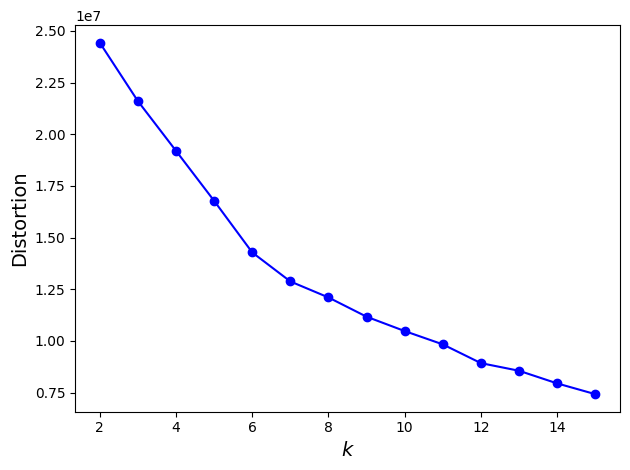

In [25]:
plt.figure()
plt.plot(Ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Distortion", fontsize=14)
plt.tight_layout()
plt.show()

In [43]:
# from sklearn.metrics import silhouette_score
# silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in kmeans_per_k]

In [44]:
# plt.figure()
# plt.plot(Ks, silhouette_scores, "bo-")
# plt.xlabel("$k$", fontsize=14)
# plt.ylabel("Silhouette score", fontsize=14)
# plt.tight_layout()
# plt.show()

In [26]:
# KMEANS 
NUM_CLUSTERS = 12
kmeans = KMeans(n_clusters=NUM_CLUSTERS, n_init=10, random_state=29, algorithm='lloyd').fit(X_pca)

In [27]:
labels = kmeans.labels_ 
clu_cen = kmeans.cluster_centers_

X_predicted = Xdata.copy()
X_predicted['cluster_1'] = labels

In [28]:
ytarget.unique()

array(['MBA', 'OMB', 'MCA', 'AMO', 'IMB', 'TJN', 'CEN', 'APO', 'ATE',
       'AST', 'TNO', 'IEO', 'HYA'], dtype=object)

In [29]:
names = ytarget.unique()

def cluster_label(alpha, names):
    for idx, i in enumerate(names): 
        if alpha == idx: 
            return i

In [30]:
clusters = [[] for i in range(0, NUM_CLUSTERS)]
for (i, l) in enumerate(labels):
    clusters[l].append(i)

In [31]:
X_predicted['predicted_cluster_label']=X_predicted['cluster_1'].apply(lambda alpha: cluster_label(alpha, names))

In [32]:
ytarget_predicted = X_predicted['predicted_cluster_label']
X_predicted['real_cluster_label'] = ytarget 

In [33]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [41]:
X_predicted['real_cluster_label']

0         MBA
1         MBA
2         MBA
3         MBA
4         MBA
         ... 
958519    MBA
958520    MBA
958521    APO
958522    MBA
958523    MBA
Name: real_cluster_label, Length: 932335, dtype: object

In [34]:
purity_score(X_predicted['real_cluster_label'], X_predicted['predicted_cluster_label'])

0.8966444464704211

In [35]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(X_predicted['real_cluster_label'], X_predicted['predicted_cluster_label'])

0.028862557078610677

In [36]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(X_predicted['real_cluster_label'], X_predicted['predicted_cluster_label'])

0.06201110486687321